# Multilayer Perceptrons

Description

# Table of Contents
- [Import Library](#import-library)
- [Read In CSV](#read-in-csv)
- [Train Model](#train-model)
    - [Neural Network 1](#neural-network-1)
    - [Neural Network 2](#neural-network-2)

## Import Library

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Read In CSV

In [18]:
eth = pd.read_csv('../data/ohlcv_daily.csv')

In [20]:
eth["tomorrow"] = eth["tomorrow"].fillna(eth["tomorrow"].mean())
eth["trend_2"] = eth["trend_2"].fillna(eth["trend_2"].mean())
eth["trend_7"] = eth["trend_7"].fillna(eth["trend_7"].mean())
eth["trend_60"] = eth["trend_60"].fillna(eth["trend_60"].mean())
eth["trend_365"] = eth["trend_365"].fillna(eth["trend_365"].mean())

In [21]:
eth.isnull().sum()

Unnamed: 0            0
open                  0
high                  0
low                   0
close                 0
volume                0
edit_count            0
sentiment             0
negative_sentiment    0
tomorrow              0
target                0
close_ratio_2         0
edit_2                0
trend_2               0
close_ratio_7         0
edit_7                0
trend_7               0
close_ratio_60        0
edit_60               0
trend_60              0
close_ratio_365       0
edit_365              0
trend_365             0
dtype: int64

# Train Model

## Neural Network 1

In [73]:
predictions = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

X = eth[predictions]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], len(predictions))

input_shape = (X_train_scaled.shape[1], len(predictions))
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], len(predictions))

history = model.fit(X_train_lstm, y_train, 
                    epochs=500, 
                    validation_data=(X_test_lstm, y_test),
                    callbacks=[early_stop])

ValueError: cannot reshape array of size 16232 into shape (2029,8,8)

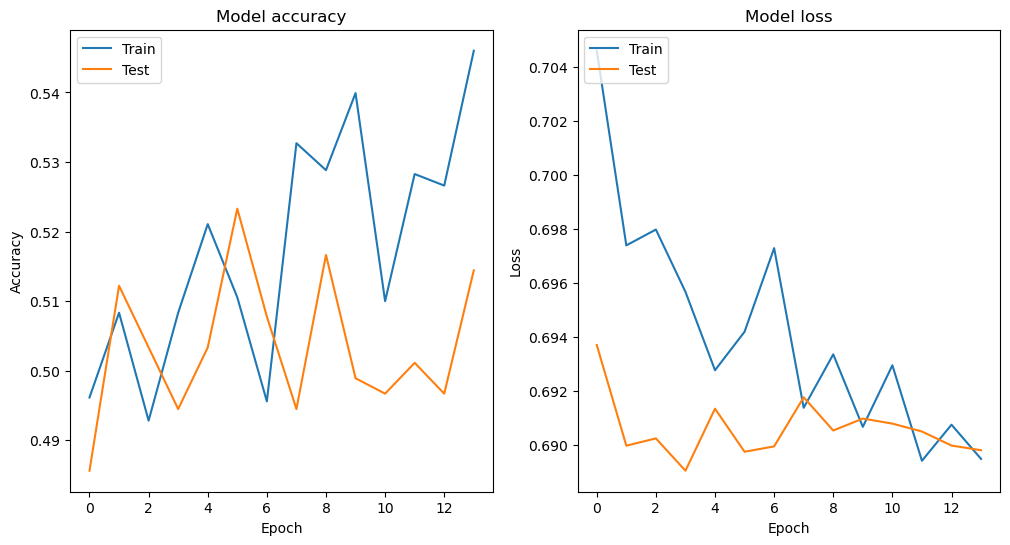

Final Test Accuracy: 51.44%


In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

15/15 [==============================] - 0s 857us/step


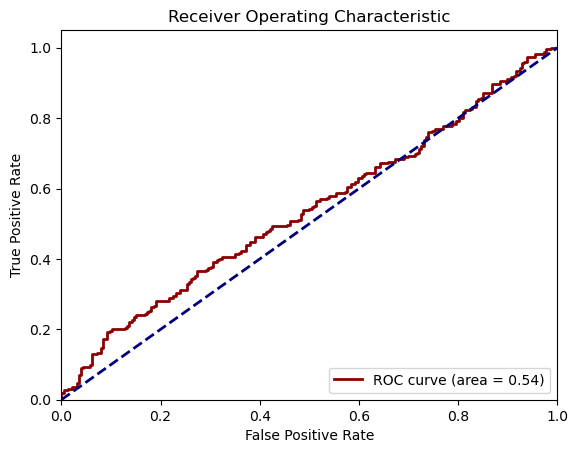

In [29]:
predictions = model.predict(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

## Neural Network 2

In [30]:
predictor_values = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

X = eth[predictor_values]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=300, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

Epoch 1/300
64/64 [==============================] - 1s 5ms/step - loss: 3.1703 - accuracy: 0.4919 - val_loss: 2.2142 - val_accuracy: 0.5044
Epoch 2/300
64/64 [==============================] - 0s 2ms/step - loss: 2.5603 - accuracy: 0.5081 - val_loss: 1.9508 - val_accuracy: 0.5044
Epoch 3/300
64/64 [==============================] - 0s 3ms/step - loss: 2.2495 - accuracy: 0.5071 - val_loss: 1.7798 - val_accuracy: 0.5044
Epoch 4/300
64/64 [==============================] - 0s 2ms/step - loss: 1.9956 - accuracy: 0.5111 - val_loss: 1.6459 - val_accuracy: 0.4956
Epoch 5/300
64/64 [==============================] - 0s 2ms/step - loss: 1.8060 - accuracy: 0.5214 - val_loss: 1.5338 - val_accuracy: 0.5310
Epoch 6/300
64/64 [==============================] - 0s 2ms/step - loss: 1.6800 - accuracy: 0.5106 - val_loss: 1.4487 - val_accuracy: 0.5221
Epoch 7/300
64/64 [==============================] - 0s 2ms/step - loss: 1.5603 - accuracy: 0.5076 - val_loss: 1.3895 - val_accuracy: 0.4735
Epoch 8/300
6

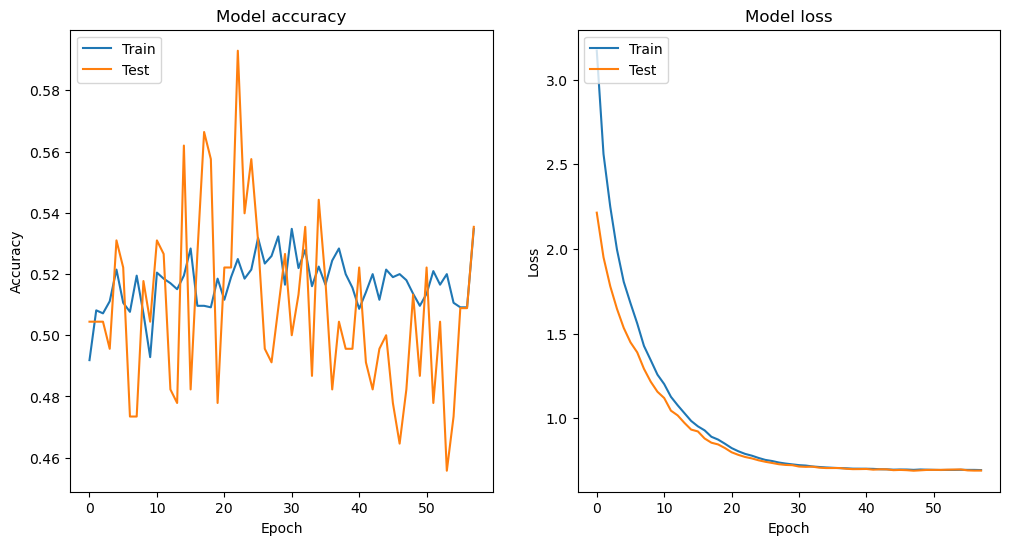

Final Test Accuracy: 53.54%


In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

8/8 [==============================] - 0s 1ms/step


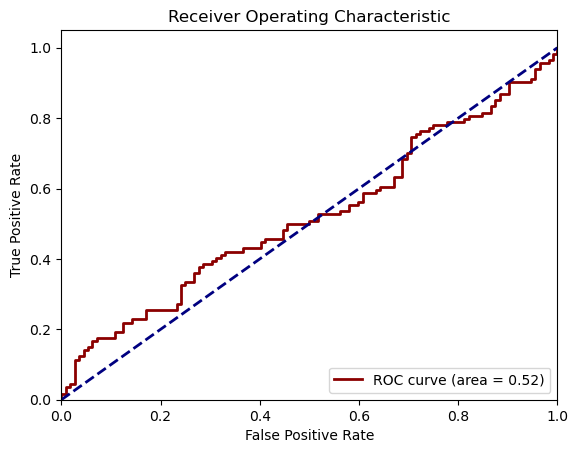

In [32]:
predictions = model.predict(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [35]:
new_predictors = ['close', 'sentiment', 'negative_sentiment', 'close_ratio_2', 'trend_2', 'edit_2', 'close_ratio_7', 'trend_7', 'edit_7', 'close_ratio_60', 'trend_60', 'edit_60', 'close_ratio_365', 'trend_365', 'edit_365']

X = eth[new_predictors]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=300, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

Epoch 1/300
64/64 [==============================] - 1s 5ms/step - loss: 3.4178 - accuracy: 0.5111 - val_loss: 2.3958 - val_accuracy: 0.4602
Epoch 2/300
64/64 [==============================] - 0s 3ms/step - loss: 2.7184 - accuracy: 0.5343 - val_loss: 2.0994 - val_accuracy: 0.5177
Epoch 3/300
64/64 [==============================] - 0s 2ms/step - loss: 2.3687 - accuracy: 0.5116 - val_loss: 1.9085 - val_accuracy: 0.4469
Epoch 4/300
64/64 [==============================] - 0s 2ms/step - loss: 2.1067 - accuracy: 0.5333 - val_loss: 1.7613 - val_accuracy: 0.4602
Epoch 5/300
64/64 [==============================] - 0s 2ms/step - loss: 1.8925 - accuracy: 0.5372 - val_loss: 1.6378 - val_accuracy: 0.4690
Epoch 6/300
64/64 [==============================] - 0s 2ms/step - loss: 1.7430 - accuracy: 0.5471 - val_loss: 1.5401 - val_accuracy: 0.4690
Epoch 7/300
64/64 [==============================] - 0s 2ms/step - loss: 1.5862 - accuracy: 0.5392 - val_loss: 1.4175 - val_accuracy: 0.5265
Epoch 8/300
6

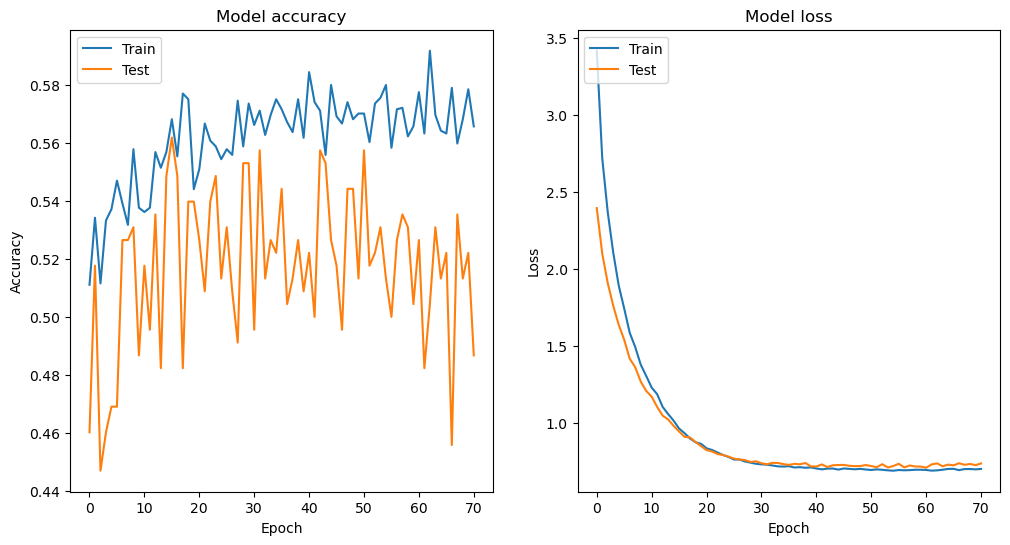

Final Test Accuracy: 48.67%


In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

8/8 [==============================] - 0s 1ms/step


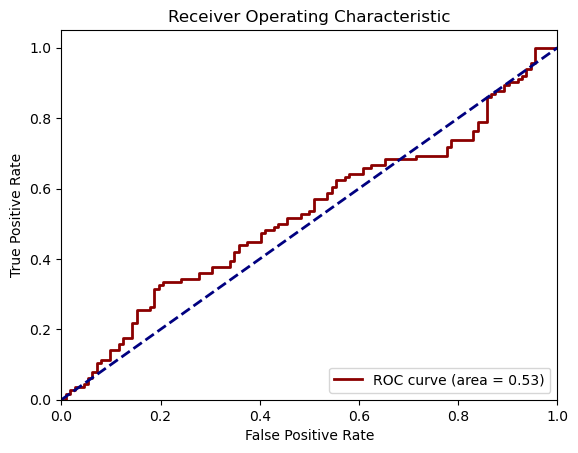

In [37]:
predictions = model.predict(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

print("Area Under the ROC Curve (AUC-ROC): ", round(auc_roc, 4))

NameError: name 'y_pred_proba' is not defined

In [315]:
eth.columns

Index(['open', 'high', 'low', 'close', 'volume', 'edit_count', 'sentiment',
       'negative_sentiment', 'tomorrow', 'target', 'close_ratio_2', 'edit_2',
       'trend_2', 'close_ratio_7', 'edit_7', 'trend_7', 'close_ratio_60',
       'edit_60', 'trend_60', 'close_ratio_365', 'edit_365', 'trend_365'],
      dtype='object')

In [279]:
eth['target'].value_counts(normalize=True)

1    0.508647
0    0.491353
Name: target, dtype: float64

In [41]:
new_predictors = ['close', 'sentiment', 'negative_sentiment', 'close_ratio_2', 'trend_2', 'edit_2', 'close_ratio_7', 'trend_7', 'edit_7', 'close_ratio_60', 'trend_60', 'edit_60', 'close_ratio_365', 'trend_365', 'edit_365']

target = eth['target']
features = eth[new_predictors]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

target_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(features_train.shape[1],), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AlphaDropout(rate=0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AlphaDropout(rate=0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AlphaDropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = target_model.fit(features_train, target_train, 
                    epochs=400, 
                    validation_data=(features_test, target_test),
                    callbacks=[early_stop])

Epoch 1/400
57/57 [==============================] - 2s 9ms/step - loss: 22.0773 - accuracy: 0.5000 - val_loss: 18.0734 - val_accuracy: 0.4967
Epoch 2/400
57/57 [==============================] - 0s 5ms/step - loss: 15.3821 - accuracy: 0.5083 - val_loss: 12.7895 - val_accuracy: 0.5388
Epoch 3/400
57/57 [==============================] - 0s 5ms/step - loss: 11.0574 - accuracy: 0.5255 - val_loss: 9.3196 - val_accuracy: 0.5831
Epoch 4/400
57/57 [==============================] - 0s 5ms/step - loss: 8.1218 - accuracy: 0.5111 - val_loss: 6.9310 - val_accuracy: 0.5033
Epoch 5/400
57/57 [==============================] - 0s 5ms/step - loss: 5.9982 - accuracy: 0.5377 - val_loss: 5.1591 - val_accuracy: 0.5211
Epoch 6/400
57/57 [==============================] - 0s 5ms/step - loss: 4.4841 - accuracy: 0.5554 - val_loss: 3.8587 - val_accuracy: 0.5543
Epoch 7/400
57/57 [==============================] - 0s 5ms/step - loss: 3.4274 - accuracy: 0.5205 - val_loss: 2.9962 - val_accuracy: 0.5299
Epoch 8/

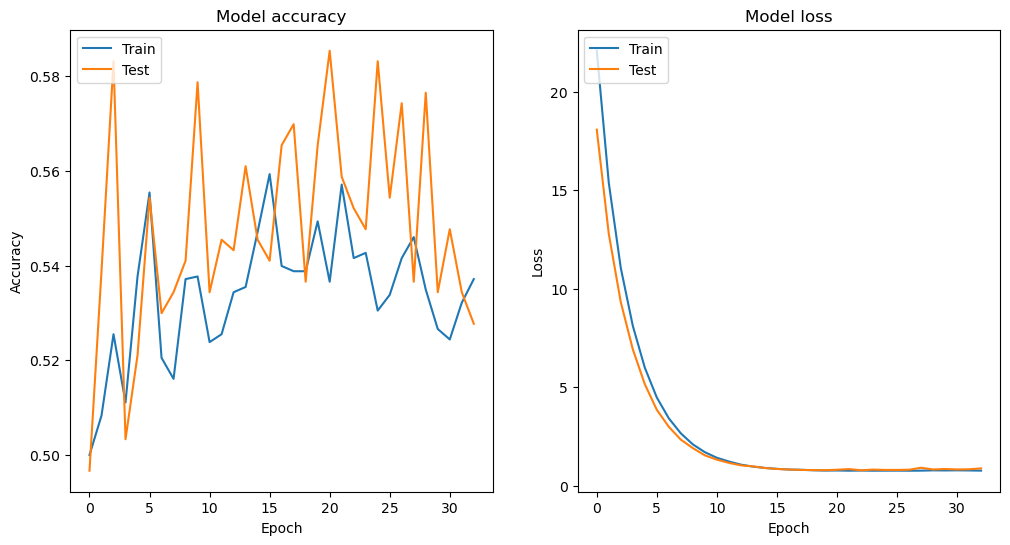

In [42]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [43]:
predictions = target_model.predict(features)
predicted_classes = (predictions >0.5).astype('int32')

71/71 [==============================] - 0s 1ms/step


Accuracy: 56.230598669623056%


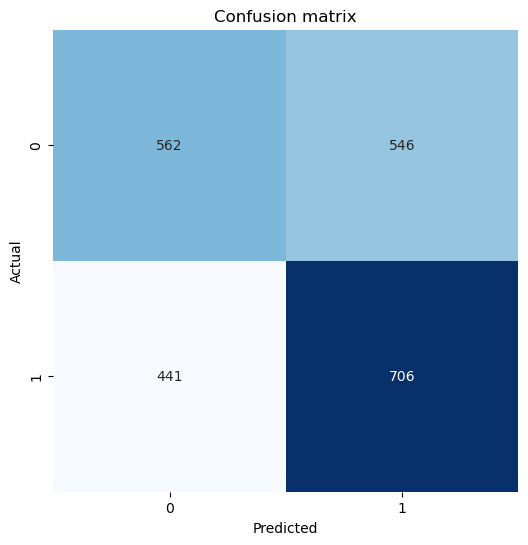

In [50]:
accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy * 100}%")

cm = confusion_matrix(target, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [372]:
df_predicted = eth.copy()

In [373]:
features_scaled = scaler.transform(features)
predictions_all = target_model.predict(features_scaled)
df_predicted['target'] = np.around(predictions_all).flatten()
df_predicted.head()

71/71 [==============================] - 0s 2ms/step


,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2017-11-09,322.15,331.70,317.29,321.32,13118.15,0.900000,-0.144123,0.261111,298.66,0.0,...,0.508651,1.000000,0.900000,0.508178,1.000000,0.900000,0.509048,1.000000,0.900000,0.511387
2017-11-10,321.32,325.61,291.00,298.66,34411.65,0.966667,-0.177429,0.294444,315.76,1.0,...,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000
2017-11-11,298.66,322.19,298.00,315.76,23836.74,0.966667,-0.177429,0.294444,306.10,0.0,...,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000
2017-11-12,315.76,318.98,300.11,306.10,48200.80,0.966667,-0.177429,0.294444,316.14,1.0,...,0.500000,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333
2017-11-13,306.10,320.69,305.91,316.14,36613.50,1.100000,-0.209260,0.327778,335.54,0.0,...,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000


In [374]:
df_predicted['target'].value_counts(normalize=True)

1.0    0.514856
0.0    0.485144
Name: target, dtype: float64

In [375]:
eth['target'].value_counts(normalize=True)

1    0.508647
0    0.491353
Name: target, dtype: float64

In [417]:
predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

target = eth['target']
features = eth[predictors]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

target_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(features_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

target_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = target_model_1.fit(features_train, target_train, 
                    epochs=100, 
                    validation_data=(features_test, target_test),
                    callbacks=[early_stop])

Epoch 1/100
57/57 [==============================] - 2s 6ms/step - loss: 3.2693 - accuracy: 0.4928 - val_loss: 2.3147 - val_accuracy: 0.4856
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 2.7547 - accuracy: 0.4756 - val_loss: 2.0713 - val_accuracy: 0.5055
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 2.4025 - accuracy: 0.5006 - val_loss: 1.9052 - val_accuracy: 0.4745
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2279 - accuracy: 0.4994 - val_loss: 1.7817 - val_accuracy: 0.4878
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 2.0011 - accuracy: 0.4933 - val_loss: 1.6594 - val_accuracy: 0.5144
Epoch 6/100
57/57 [==============================] - 0s 3ms/step - loss: 1.8600 - accuracy: 0.5083 - val_loss: 1.5904 - val_accuracy: 0.5011
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 1.7203 - accuracy: 0.5172 - val_loss: 1.4964 - val_accuracy: 0.4878
Epoch 8/100
5

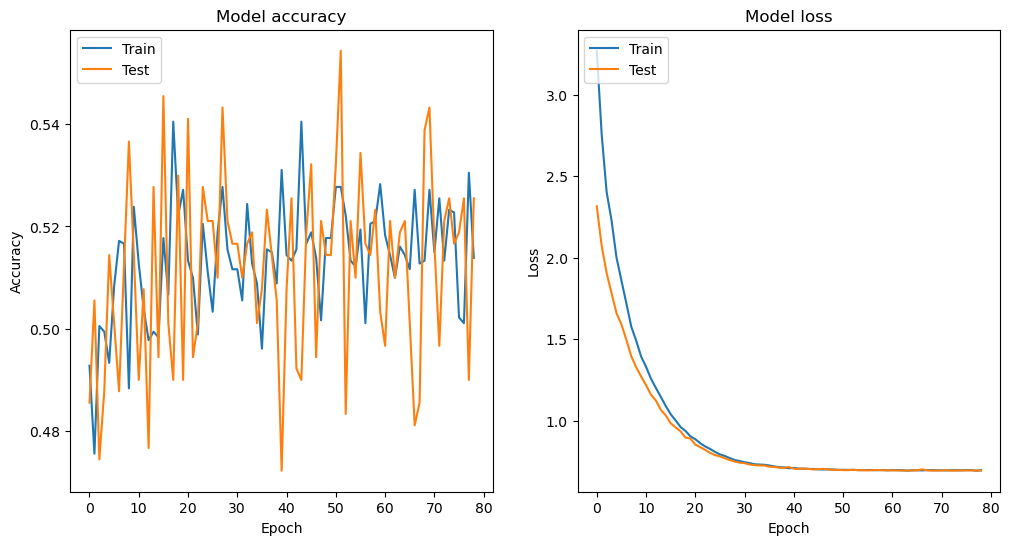

In [418]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [419]:
predictions = target_model_1.predict(features)
predicted_classes = (predictions > 0.5).astype('int32')

71/71 [==============================] - 0s 1ms/step


Accuracy: 52.372505543237246%


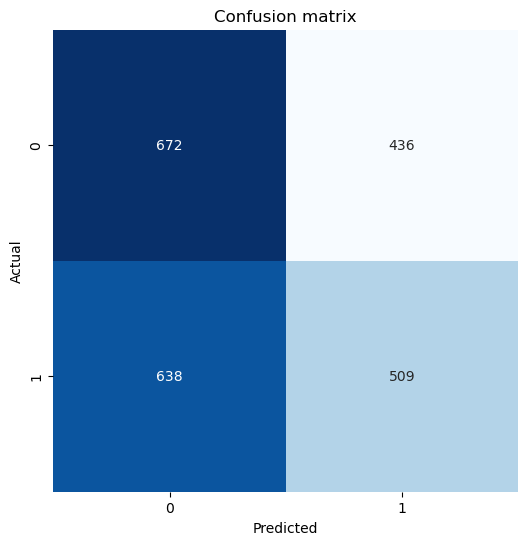

In [420]:
accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy * 100}%")

cm = confusion_matrix(target, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [421]:
df_predicted = eth.copy()
features_scaled = scaler.transform(features)
predictions_all = target_model.predict(features_scaled)
df_predicted['target'] = np.around(predictions_all).flatten()
df_predicted.head()

71/71 [==============================] - 0s 957us/step


,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2017-11-09,322.15,331.70,317.29,321.32,13118.15,0.900000,-0.144123,0.261111,298.66,1.0,...,0.508651,1.000000,0.900000,0.508178,1.000000,0.900000,0.509048,1.000000,0.900000,0.511387
2017-11-10,321.32,325.61,291.00,298.66,34411.65,0.966667,-0.177429,0.294444,315.76,1.0,...,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000
2017-11-11,298.66,322.19,298.00,315.76,23836.74,0.966667,-0.177429,0.294444,306.10,1.0,...,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000
2017-11-12,315.76,318.98,300.11,306.10,48200.80,0.966667,-0.177429,0.294444,316.14,1.0,...,0.500000,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333
2017-11-13,306.10,320.69,305.91,316.14,36613.50,1.100000,-0.209260,0.327778,335.54,1.0,...,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000


In [422]:
df_predicted['target'].value_counts(normalize=True)

1.0    0.704213
0.0    0.295787
Name: target, dtype: float64

In [423]:
# Baseline
eth['target'].value_counts(normalize=True)

1    0.508647
0    0.491353
Name: target, dtype: float64

In [424]:
fe_predictors = ['close', 'sentiment', 'negative_sentiment', 'close_ratio_2', 'trend_2', 'edit_2', 'close_ratio_7', 'trend_7', 'edit_7', 'close_ratio_60', 'trend_60', 'edit_60', 'close_ratio_365', 'trend_365', 'edit_365']

target = eth['target']
features = eth[fe_predictors]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

target_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(features_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

target_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = target_model_2.fit(features_train, target_train, 
                    epochs=100, 
                    validation_data=(features_test, target_test),
                    callbacks=[early_stop])

Epoch 1/100
57/57 [==============================] - 2s 6ms/step - loss: 3.4122 - accuracy: 0.5067 - val_loss: 2.3954 - val_accuracy: 0.5499
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 2.7606 - accuracy: 0.5177 - val_loss: 2.0903 - val_accuracy: 0.5521
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 2.3872 - accuracy: 0.5200 - val_loss: 1.9051 - val_accuracy: 0.5078
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 2.1471 - accuracy: 0.5183 - val_loss: 1.7559 - val_accuracy: 0.5610
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 1.9180 - accuracy: 0.5455 - val_loss: 1.6331 - val_accuracy: 0.6009
Epoch 6/100
57/57 [==============================] - 0s 3ms/step - loss: 1.7733 - accuracy: 0.5549 - val_loss: 1.5479 - val_accuracy: 0.5144
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 1.6604 - accuracy: 0.5244 - val_loss: 1.4673 - val_accuracy: 0.5366
Epoch 8/100
5

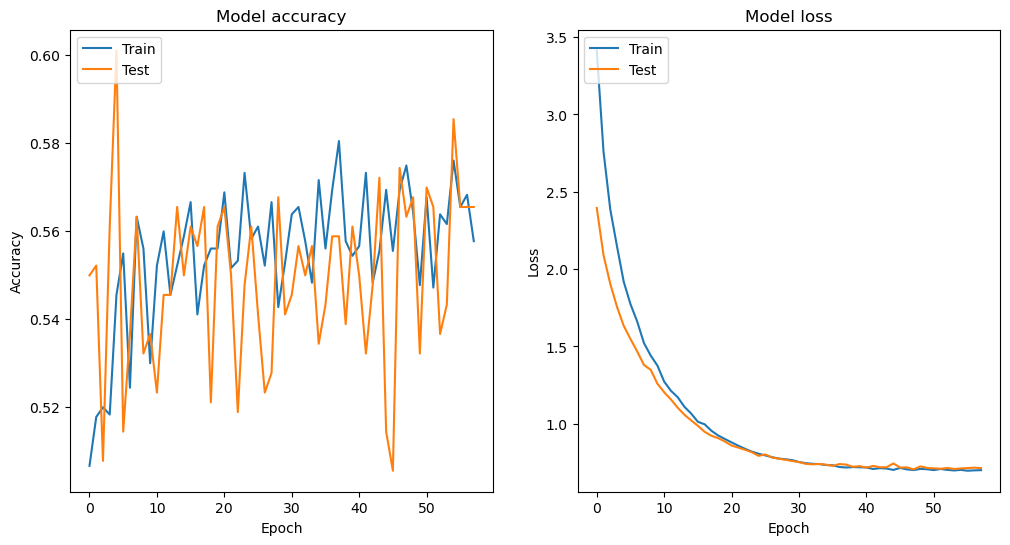

In [425]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [426]:
predictions = target_model_2.predict(features)
predicted_classes = (predictions > 0.5).astype('int32')

71/71 [==============================] - 0s 957us/step


Accuracy: 58.58093126385809%


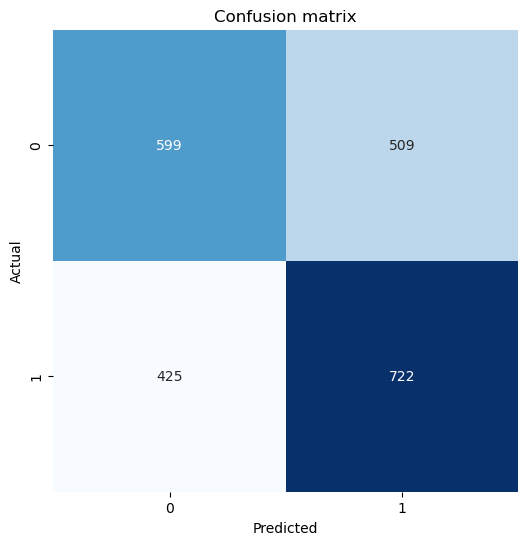

In [427]:
accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy * 100}%")

cm = confusion_matrix(target, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [429]:
df_predicted2 = eth.copy()
features_scaled = scaler.transform(features)
predictions_all = target_model_2.predict(features_scaled)
df_predicted2['target'] = np.around(predictions_all).flatten()
df_predicted2.head()

71/71 [==============================] - 0s 1ms/step


,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2017-11-09,322.15,331.70,317.29,321.32,13118.15,0.900000,-0.144123,0.261111,298.66,1.0,...,0.508651,1.000000,0.900000,0.508178,1.000000,0.900000,0.509048,1.000000,0.900000,0.511387
2017-11-10,321.32,325.61,291.00,298.66,34411.65,0.966667,-0.177429,0.294444,315.76,1.0,...,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000
2017-11-11,298.66,322.19,298.00,315.76,23836.74,0.966667,-0.177429,0.294444,306.10,1.0,...,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000
2017-11-12,315.76,318.98,300.11,306.10,48200.80,0.966667,-0.177429,0.294444,316.14,1.0,...,0.500000,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333
2017-11-13,306.10,320.69,305.91,316.14,36613.50,1.100000,-0.209260,0.327778,335.54,1.0,...,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000


In [430]:
df_predicted2['target'].value_counts(normalize=True)

1.0    0.537472
0.0    0.462528
Name: target, dtype: float64

In [431]:
# Baseline
eth['target'].value_counts(normalize=True)

1    0.508647
0    0.491353
Name: target, dtype: float64

In [66]:
predictors2 = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

target = eth['target']
features = eth[predictors2]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

target_model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', input_shape=(features_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(256, activation='leaky_relu'),
    tf.keras.layers.Dense(256, activation='leaky_relu'),
    tf.keras.layers.Dense(units=1)
])

target_model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history3 = target_model_3.fit(features_train, target_train, 
                    epochs=100, 
                    validation_data=(features_test, target_test),
                    callbacks=[early_stop])

Epoch 1/100
57/57 [==============================] - 1s 5ms/step - loss: 1.0521 - accuracy: 0.4978 - val_loss: 0.7449 - val_accuracy: 0.4900
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 0.7747 - accuracy: 0.4922 - val_loss: 0.6978 - val_accuracy: 0.5166
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7317 - accuracy: 0.4867 - val_loss: 0.7317 - val_accuracy: 0.4856
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7187 - accuracy: 0.5006 - val_loss: 0.7046 - val_accuracy: 0.4878
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7082 - accuracy: 0.4878 - val_loss: 0.6985 - val_accuracy: 0.5055
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.5044 - val_loss: 0.6957 - val_accuracy: 0.5166
Epoch 7/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.5083 - val_loss: 0.6954 - val_accuracy: 0.4945
Epoch 8/100
5

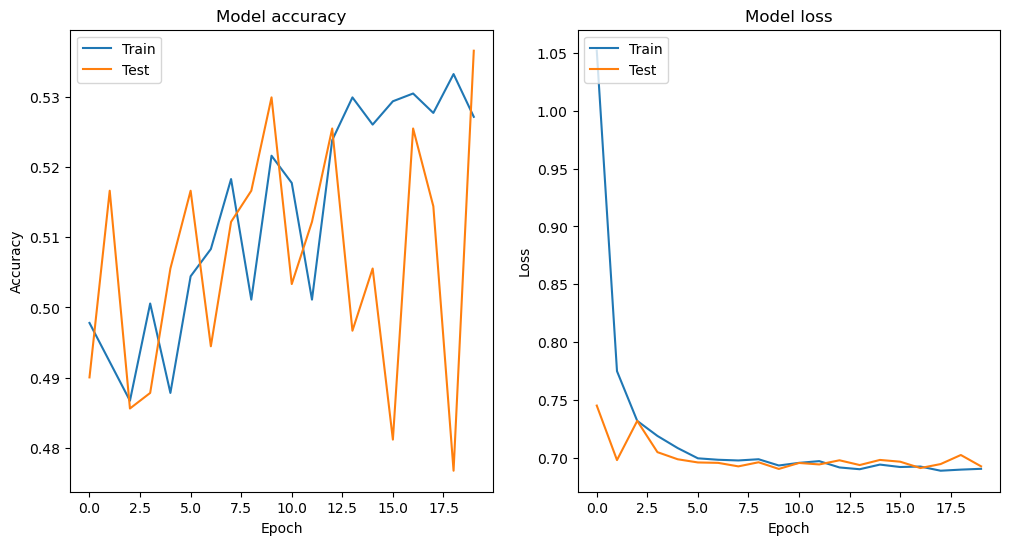

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [68]:
predictions = target_model_3.predict(features)
predicted_classes = (predictions > 0.5).astype('int32')

71/71 [==============================] - 0s 1ms/step


Accuracy: 56.14190687361419%


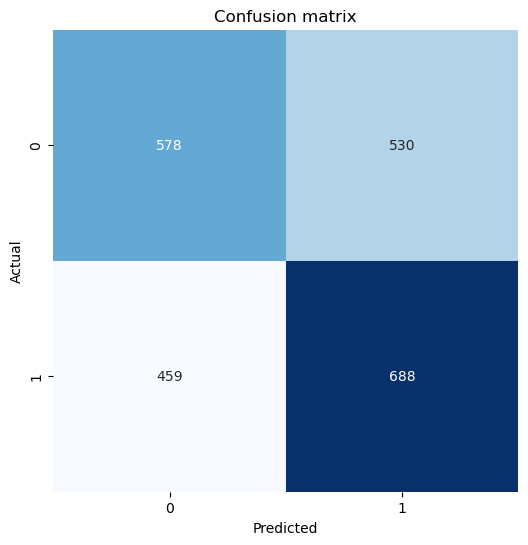

In [69]:
accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy * 100}%")

cm = confusion_matrix(target, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [455]:
df_predicted3 = eth.copy()
features_scaled = scaler.transform(features)
predictions_all = target_model_3.predict(features_scaled)
df_predicted3['target'] = np.around(predictions_all).flatten()
df_predicted3.head()

71/71 [==============================] - 0s 1ms/step


,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2017-11-09,322.15,331.70,317.29,321.32,13118.15,0.900000,-0.144123,0.261111,298.66,0.0,...,0.508651,1.000000,0.900000,0.508178,1.000000,0.900000,0.509048,1.000000,0.900000,0.511387
2017-11-10,321.32,325.61,291.00,298.66,34411.65,0.966667,-0.177429,0.294444,315.76,0.0,...,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000
2017-11-11,298.66,322.19,298.00,315.76,23836.74,0.966667,-0.177429,0.294444,306.10,0.0,...,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000
2017-11-12,315.76,318.98,300.11,306.10,48200.80,0.966667,-0.177429,0.294444,316.14,0.0,...,0.500000,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333
2017-11-13,306.10,320.69,305.91,316.14,36613.50,1.100000,-0.209260,0.327778,335.54,1.0,...,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000


In [456]:
df_predicted3['target'].value_counts(normalize=True)

0.0    0.689579
1.0    0.310421
Name: target, dtype: float64

In [457]:
# Baseline
eth['target'].value_counts(normalize=True)

1    0.508647
0    0.491353
Name: target, dtype: float64

In [439]:
fe_predictors2 = ['close', 'sentiment', 'negative_sentiment', 'close_ratio_2', 'trend_2', 'edit_2', 'close_ratio_7', 'trend_7', 'edit_7', 'close_ratio_60', 'trend_60', 'edit_60', 'close_ratio_365', 'trend_365', 'edit_365']

target = eth['target']
features = eth[fe_predictors2]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

target_model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', input_shape=(features_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(256, activation='leaky_relu'),
    tf.keras.layers.Dense(256, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

target_model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history4 = target_model_4.fit(features_train, target_train, 
                    epochs=100, 
                    validation_data=(features_test, target_test),
                    callbacks=[early_stop])

Epoch 1/100
57/57 [==============================] - 1s 7ms/step - loss: 0.6987 - accuracy: 0.5017 - val_loss: 0.6912 - val_accuracy: 0.5432
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5477 - val_loss: 0.6842 - val_accuracy: 0.5632
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5538 - val_loss: 0.6879 - val_accuracy: 0.5499
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5698 - val_loss: 0.6866 - val_accuracy: 0.5632
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.5820 - val_loss: 0.7018 - val_accuracy: 0.5366
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.5881 - val_loss: 0.6901 - val_accuracy: 0.5632
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6031 - val_loss: 0.7096 - val_accuracy: 0.5277
Epoch 8/100
5

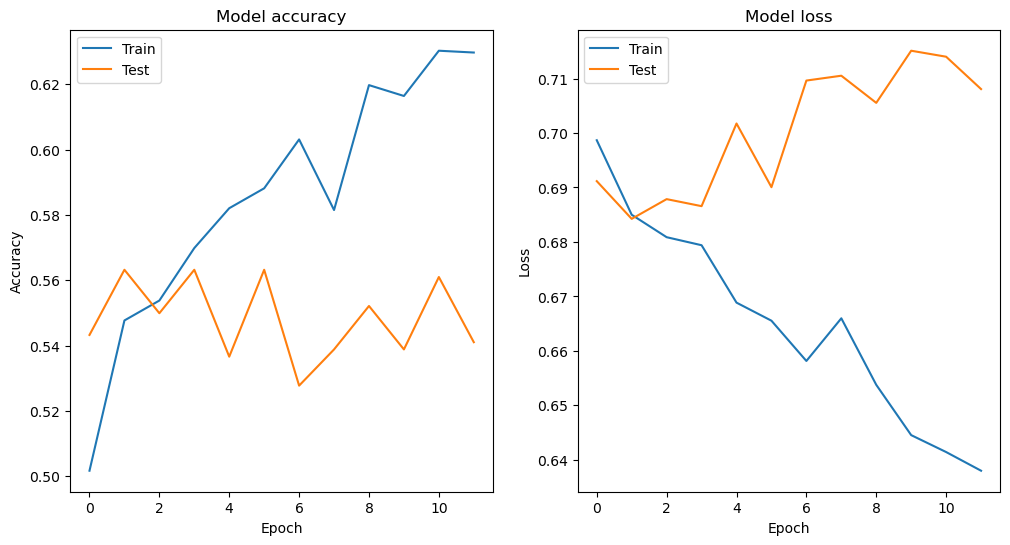

In [440]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [446]:
predictions = target_model_4.predict(features)
predicted_classes = (predictions > 0.5).astype('int32')

71/71 [==============================] - 0s 3ms/step


Accuracy: 57.827050997782706%


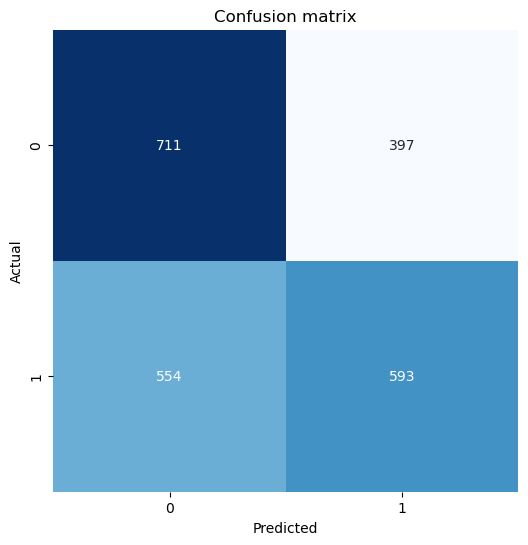

In [447]:
accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy * 100}%")

cm = confusion_matrix(target, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [448]:
df_predicted4 = eth.copy()
features_scaled = scaler.transform(features)
predictions_all = target_model_4.predict(features_scaled)
df_predicted4['target'] = np.around(predictions_all).flatten()
df_predicted4.head()

71/71 [==============================] - 0s 1ms/step


,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2017-11-09,322.15,331.70,317.29,321.32,13118.15,0.900000,-0.144123,0.261111,298.66,0.0,...,0.508651,1.000000,0.900000,0.508178,1.000000,0.900000,0.509048,1.000000,0.900000,0.511387
2017-11-10,321.32,325.61,291.00,298.66,34411.65,0.966667,-0.177429,0.294444,315.76,1.0,...,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000,0.963450,0.933333,0.000000
2017-11-11,298.66,322.19,298.00,315.76,23836.74,0.966667,-0.177429,0.294444,306.10,0.0,...,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000,1.012332,0.944444,0.500000
2017-11-12,315.76,318.98,300.11,306.10,48200.80,0.966667,-0.177429,0.294444,316.14,1.0,...,0.500000,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333,0.985956,0.950000,0.333333
2017-11-13,306.10,320.69,305.91,316.14,36613.50,1.100000,-0.209260,0.327778,335.54,1.0,...,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000,1.014583,0.980000,0.500000


In [449]:
df_predicted4['target'].value_counts(normalize=True)

0.0    0.566297
1.0    0.433703
Name: target, dtype: float64

In [450]:
# Baseline
eth['target'].value_counts(normalize=True)

1    0.508647
0    0.491353
Name: target, dtype: float64

## END

In [414]:
eth.columns

Index(['open', 'high', 'low', 'close', 'volume', 'edit_count', 'sentiment',
       'negative_sentiment', 'tomorrow', 'target', 'close_ratio_2', 'edit_2',
       'trend_2', 'close_ratio_7', 'edit_7', 'trend_7', 'close_ratio_60',
       'edit_60', 'trend_60', 'close_ratio_365', 'edit_365', 'trend_365'],
      dtype='object')

In [415]:
some_predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

target = eth['target']
features = eth[some_predictors]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

input_shape = (X_train_scaled.shape[1],)
target_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

target_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = target_model_1.fit(features_train, target_train, epochs=300, validation_data=(features_test, target_test))

Epoch 1/300


ValueError: in user code:

    File "C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_86" is incompatible with the layer: expected shape=(None, 9), found shape=(None, 8)


In [243]:
predictor_values = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

X = eth[predictor_values]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=500, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

Epoch 1/500
57/57 [==============================] - 2s 14ms/step - loss: 0.7009 - accuracy: 0.4917 - val_loss: 0.6939 - val_accuracy: 0.4435
Epoch 2/500
57/57 [==============================] - 1s 11ms/step - loss: 0.6958 - accuracy: 0.5083 - val_loss: 0.6917 - val_accuracy: 0.4989
Epoch 3/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5133 - val_loss: 0.6920 - val_accuracy: 0.5033
Epoch 4/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6955 - accuracy: 0.5116 - val_loss: 0.6925 - val_accuracy: 0.4989
Epoch 5/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.4900
Epoch 6/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6923 - val_accuracy: 0.5055
Epoch 7/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 

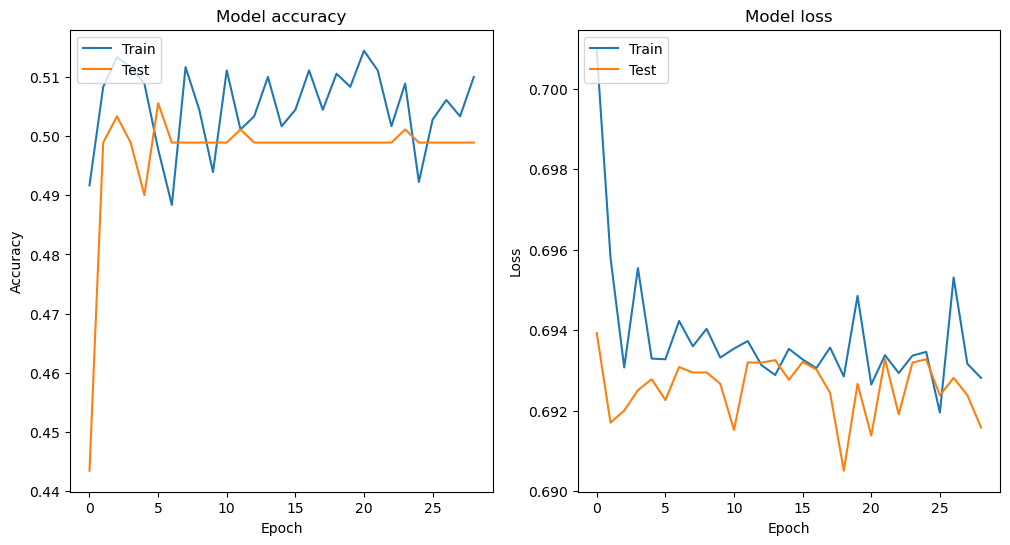

Final Test Accuracy: 49.89%


In [244]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

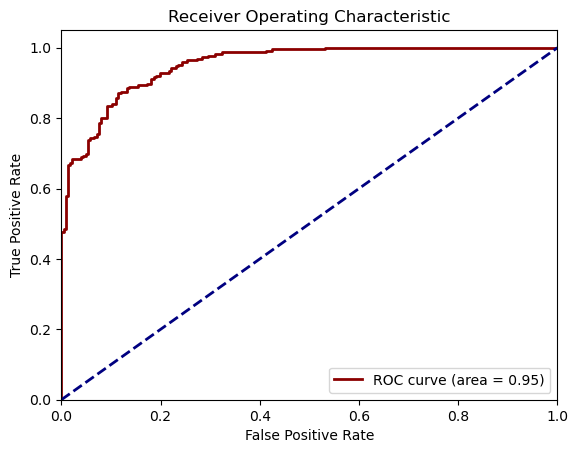

In [245]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
predictor_values = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment', 'tomorrow']

X = eth[predictor_values]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=500, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

## Hour

In [59]:
eth_hour = pd.read_csv('../data/ohlcv_hour.csv')

In [60]:
eth_hour.fillna(eth_hour.mean(), inplace=True)

C:\Users\Crypt\AppData\Local\Temp\ipykernel_8104\7310399.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  eth_hour.fillna(eth_hour.mean(), inplace=True)


In [61]:
eth_hour.columns

Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'edit_count',
       'sentiment', 'negative_sentiment', 'next_hour', 'target',
       'close_ratio_1', 'edit_1', 'trend_1', 'close_ratio_2', 'edit_2',
       'trend_2', 'close_ratio_6', 'edit_6', 'trend_6', 'close_ratio_12',
       'edit_12', 'trend_12'],
      dtype='object')

In [62]:
new_predictors = ['close', 'sentiment', 'negative_sentiment', 'close_ratio_1', 'trend_1', 'edit_1', 'close_ratio_2', 'trend_2', 'edit_2', 'close_ratio_6', 'trend_6', 'edit_6', 'close_ratio_12', 'trend_12', 'edit_12']

target = eth_hour['target']
features = eth_hour[new_predictors]
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

hour_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(features_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

hour_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = hour_model.fit(features_train, target_train, 
                    epochs=400, 
                    validation_data=(features_test, target_test),
                    callbacks=[early_stop])

Epoch 1/400
1241/1241 [==============================] - 3s 2ms/step - loss: 1.0889 - accuracy: 0.5308 - val_loss: 0.6976 - val_accuracy: 0.5631
Epoch 2/400
1241/1241 [==============================] - 2s 1ms/step - loss: 0.7309 - accuracy: 0.5423 - val_loss: 0.6814 - val_accuracy: 0.5737
Epoch 3/400
1241/1241 [==============================] - 2s 1ms/step - loss: 0.6990 - accuracy: 0.5611 - val_loss: 0.6748 - val_accuracy: 0.5873
Epoch 4/400
1241/1241 [==============================] - 2s 1ms/step - loss: 0.6869 - accuracy: 0.5720 - val_loss: 0.6725 - val_accuracy: 0.5923
Epoch 5/400
1241/1241 [==============================] - 2s 2ms/step - loss: 0.6821 - accuracy: 0.5795 - val_loss: 0.6721 - val_accuracy: 0.5960
Epoch 6/400
1241/1241 [==============================] - 2s 1ms/step - loss: 0.6752 - accuracy: 0.5862 - val_loss: 0.6742 - val_accuracy: 0.5878
Epoch 7/400
1241/1241 [==============================] - 2s 1ms/step - loss: 0.6738 - accuracy: 0.5888 - val_loss: 0.6705 - val_ac

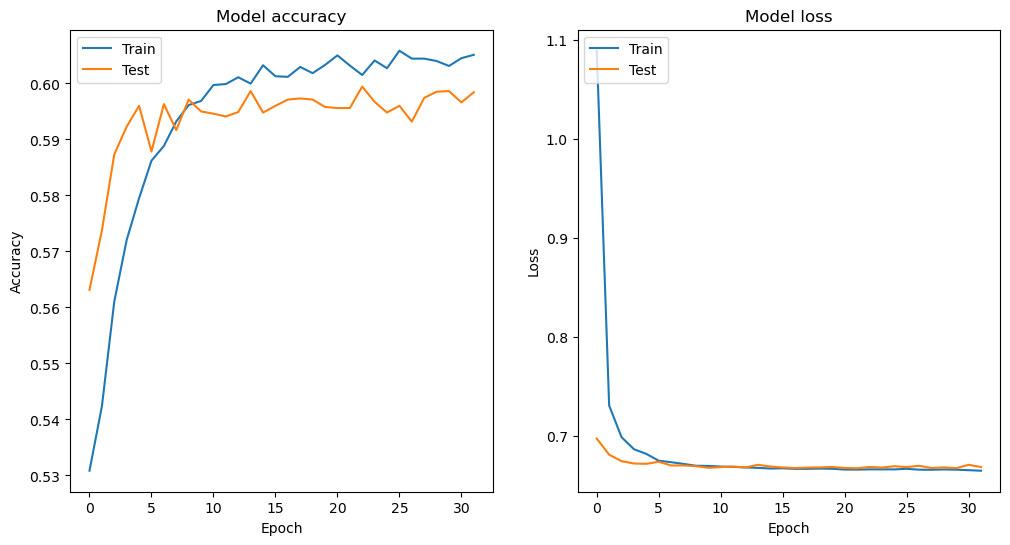

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [64]:
accuracy = accuracy_score(target, predicted_classes)
print(f"Accuracy: {accuracy * 100}%")

cm = confusion_matrix(target, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [49603, 2255]

In [65]:
predictions = hour_model.predict(features)
predicted_classes = (predictions >0.5).astype('int32')

1551/1551 [==============================] - 1s 801us/step


In [410]:
df_predicted = eth_hour.copy()

In [411]:
features_scaled = scaler.transform(features)
predictions_all = hour_model.predict(features_scaled)
df_predicted['target'] = np.around(predictions_all).flatten()
df_predicted.head()

1551/1551 [==============================] - 1s 835us/step


,Unnamed: 0,open,high,low,close,volume,edit_count,sentiment,negative_sentiment,next_hour,...,trend_1,close_ratio_2,edit_2,trend_2,close_ratio_6,edit_6,trend_6,close_ratio_12,edit_12,trend_12
0,2018-05-15,732.10,736.67,730.94,733.00,1043.91,1.0,-0.228246,0.308333,707.38,...,0.495968,1.000000,1.0,0.495958,1.000000,1.0,0.495943,1.000000,1.0,0.495947
1,2018-05-15,700.99,710.15,699.05,707.38,255.89,1.0,-0.228246,0.308333,700.99,...,0.000000,0.982213,1.0,0.000000,0.982213,1.0,0.000000,0.982213,1.0,0.000000
2,2018-05-15,707.84,711.29,695.74,700.99,1029.83,1.0,-0.228246,0.308333,707.84,...,0.000000,0.995463,1.0,0.000000,0.982068,1.0,0.000000,0.982068,1.0,0.000000
3,2018-05-15,712.48,714.44,707.39,707.84,156.07,1.0,-0.228246,0.308333,712.48,...,1.000000,1.004862,1.0,0.500000,0.993735,1.0,0.333333,0.993735,1.0,0.333333
4,2018-05-15,713.00,714.99,709.41,712.48,418.57,1.0,-0.228246,0.308333,713.00,...,1.000000,1.003267,1.0,1.000000,1.000199,1.0,0.500000,1.000199,1.0,0.500000


In [412]:
df_predicted['target'].value_counts(normalize=True)

0.0    0.500534
1.0    0.499466
Name: target, dtype: float64

In [382]:
eth_hour['target'].value_counts(normalize=True)

0    0.504042
1    0.495958
Name: target, dtype: float64